In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Brief description of features in train, test, and validation

|Indicator|	Description|
| :---------- | :----------:|
|WS10M_MIN|	Minimum Wind Speed at 10 Meters (m/s)|
|QV2M|	Specific Humidity at 2 Meters (g/kg)|
|T2M_RANGE|	Temperature Range at 2 Meters (C)|
|WS10M|	Wind Speed at 10 Meters (m/s)|
|T2M|	Temperature at 2 Meters (C)|
|WS50M_MIN|	Minimum Wind Speed at 50 Meters (m/s)|
|T2M_MAX|	Maximum Temperature at 2 Meters (C)|
|WS50M|	Wind Speed at 50 Meters (m/s)|
|TS|	Earth Skin Temperature (C)|
|WS50M_RANGE|	Wind Speed Range at 50 Meters (m/s)|
|WS50M_MAX|	Maximum Wind Speed at 50 Meters (m/s)|
|WS10M_MAX|	Maximum Wind Speed at 10 Meters (m/s)|
|WS10M_RANGE|	Wind Speed Range at 10 Meters (m/s)|
|PS|	Surface Pressure (kPa)|
|T2MDEW|	Dew/Frost Point at 2 Meters (C)|
|T2M_MIN|	Minimum Temperature at 2 Meters (C)|
|T2MWET|	Wet Bulb Temperature at 2 Meters (C)|
|PRECTOT|	Precipitation (mm day-1)|

In [2]:
soil = pd.read_csv('data/soil.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/validation.csv')

soil.shape, train.shape, test.shape, valid.shape

((3109, 32), (19300680, 21), (2271948, 21), (2268840, 21))

Notice that fips is similar to ZIP code. One idea is to use fips instead of lat and lon when merging (or combining two dataframes)

In [3]:
soil.head(3)

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1


In [4]:
train.head(3)

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN


**score** is the target variable

nan in score means no drought.

It ranges from 0 to 4 where 4 is the exceptional drought.

In [5]:
d_none = train[train['score'].isna()]
d0 = train[train['score']<1]
d1 = train[(train['score']>=1) & (train['score']<2)]
d2 = train[(train['score']>=2) & (train['score']<3)]
d3 = train[(train['score']>=3) & (train['score']<4)]
d4 = train[train['score']>=4]

In [6]:
d_none.shape[0], d0.shape[0], d1.shape[0], d2.shape[0], d3.shape[0], d4.shape[0]

(16543884, 1794623, 424353, 265995, 169049, 102776)

#### Notes

1. To make predictions simpler, instead of using floating points for targets, convert them into integers 0 to 4
2. nan values cannot be used for target variable. Assign the value of 9 for nan(no drought)

There are 6 different targets. Choose k values to sample from each data

In [7]:
k = 20000
random_state = 123

d_none = d_none.sample(k, random_state=random_state)
d0 = d0.sample(k, random_state=random_state)
d1 = d1.sample(k, random_state=random_state)
d2 = d2.sample(k, random_state=random_state)
d3 = d3.sample(k, random_state=random_state)
d4 = d4.sample(k, random_state=random_state)

d_none.shape[0], d0.shape[0], d1.shape[0], d2.shape[0], d3.shape[0], d4.shape[0]

(20000, 20000, 20000, 20000, 20000, 20000)

In [8]:
# Append all sets into one dataframe
df = pd.DataFrame()

for i, d in enumerate([d0, d1, d2, d3, d4, d_none]):
    
    if i == 5:
        d['score'] = 9
    else:
        d['score'] = i
    df = df.append(d, ignore_index=True)

In [9]:
df.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,30236.781267,2.332326,95.781094,7.662575,13.808635,6.542439,6.587756,20.123376,8.103614,12.019791,13.981030,3.599079,5.293099,1.907129,3.385951,5.526645,7.862876,3.068336,4.794526,3.166667
std,15443.630473,5.719392,6.194043,4.591977,11.121486,10.165509,10.099440,11.815867,10.677808,4.121191,11.455157,1.833303,2.603334,1.333582,1.956763,2.290875,2.833577,2.105248,2.197602,2.910720
min,1001.000000,0.000000,67.120000,0.200000,-29.070000,-32.370000,-30.280000,-23.780000,-37.230000,0.370000,-30.510000,0.360000,0.750000,0.000000,0.300000,0.600000,1.120000,0.000000,0.350000,0.000000
25%,17197.000000,0.000000,94.130000,3.710000,5.420000,-1.510000,-1.460000,11.630000,-0.090000,9.080000,5.340000,2.180000,3.220000,0.940000,1.900000,3.810000,5.720000,1.390000,3.210000,1.000000
50%,30053.000000,0.120000,98.005000,6.740000,15.170000,7.200000,7.200000,21.940000,8.900000,12.070000,15.250000,3.210000,4.830000,1.650000,2.960000,5.140000,7.410000,2.700000,4.360000,2.500000
75%,46091.500000,1.730000,99.900000,11.140000,23.000000,15.190000,15.190000,29.440000,16.940000,14.980000,23.370000,4.640000,6.860000,2.570000,4.400000,6.890000,9.560000,4.350000,5.940000,4.000000
max,56043.000000,160.110000,103.730000,21.770000,38.700000,26.350000,26.350000,46.780000,31.260000,30.170000,41.860000,16.620000,20.410000,13.420000,15.670000,20.550000,25.560000,16.850000,19.220000,9.000000


In [10]:
df['score'].value_counts().sort_index()

0    20000
1    20000
2    20000
3    20000
4    20000
9    20000
Name: score, dtype: int64

### Plots for features

In [11]:
df.shape

(120000, 21)

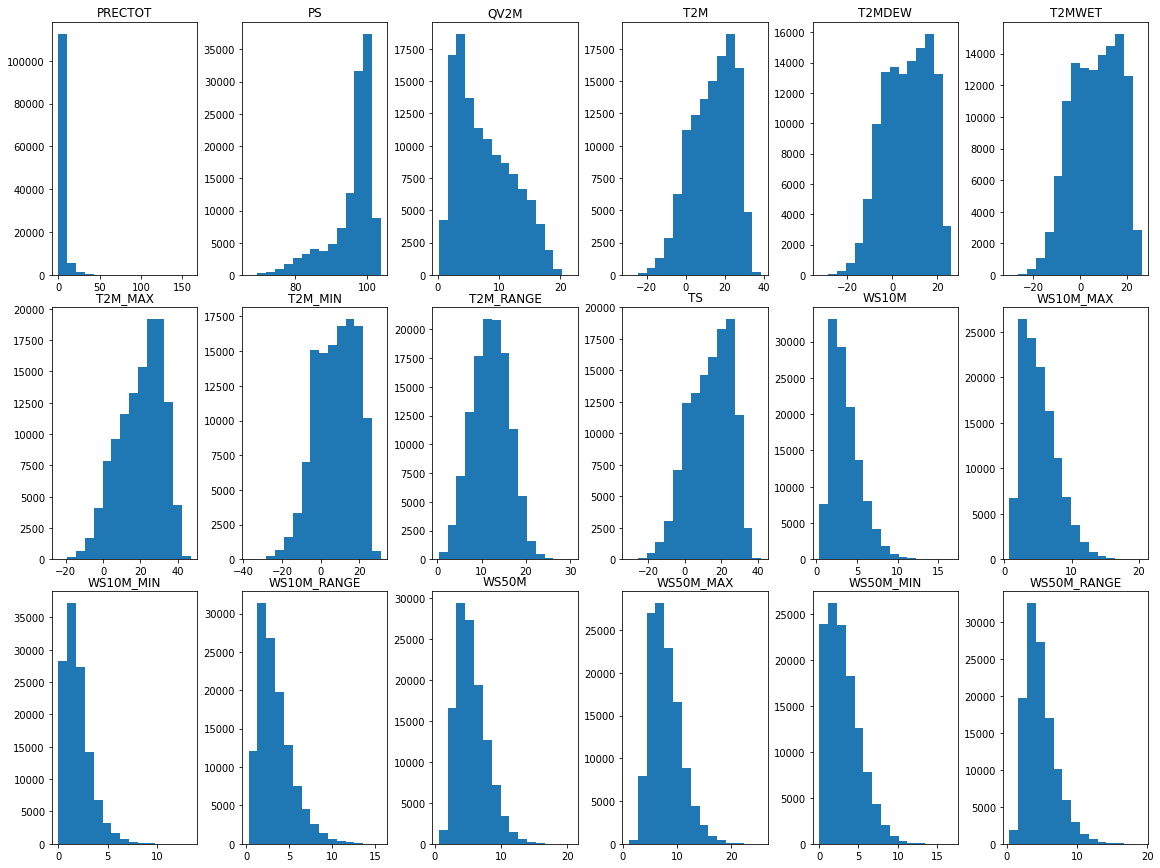

In [12]:
# Histogram for each feature
fig, ax = plt.subplots(3, 6, figsize=(16, 12))
fig.tight_layout()

for i in range(18):
    
    col = i % 6
    row = i // 6
    
    ax[row][col].hist(df.iloc[:, i+2], bins=15)
    ax[row][col].set_title(df.columns[i+2])
    
plt.show()

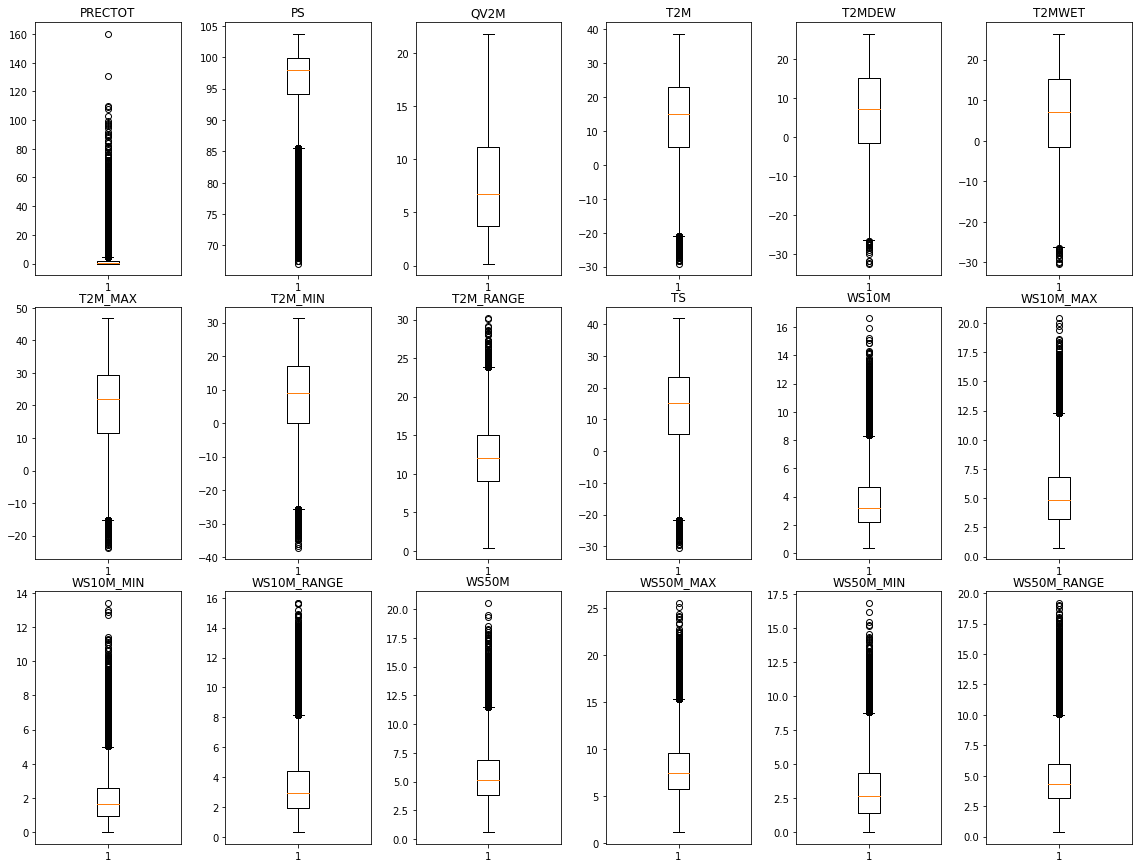

In [13]:
# Boxplot for each feature
fig, ax = plt.subplots(3, 6, figsize=(16, 12))
fig.tight_layout()

for i in range(18):
    
    col = i % 6
    row = i // 6
    
    ax[row][col].boxplot(df.iloc[:, i+2])
    ax[row][col].set_title(df.columns[i+2])
    
plt.show()

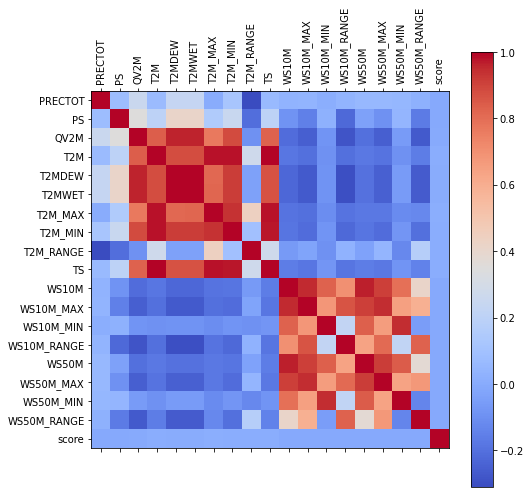

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
im = ax.matshow(df.iloc[:, 2:].corr(), cmap='coolwarm')
plt.xticks(range(df.columns[2:].shape[0]), df.columns[2:], rotation='vertical')
plt.yticks(range(df.columns[2:].shape[0]), df.columns[2:])
fig.colorbar(im, ax=ax)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
# Apply PCA
from sklearn.decomposition import PCA

# Drop date column for the current project since we are not using time series models
X = df.drop(columns=['date', 'score'])
y = df['score']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=random_state)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


n_components = 10

pca = PCA(n_components=n_components).fit(X_train)
X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)

print(X_train.shape, X_valid.shape)

(96000, 19) (24000, 19) (96000,) (24000,)
(96000, 10) (24000, 10)


In [16]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [49]:
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=250, learning_rate=.001,
                            objective='multi:softprob', booster='gbtree',
                            n_jobs=2, random_state=random_state)

In [ ]:
xgb_clf.fit(X_train,y_train)

preds = xgb_clf.predict(X_train)
valid_preds = xgb_clf.predict(X_valid)

loss = mean_squared_error(y_train, preds)
valid_loss = mean_squared_error(y_valid, valid_preds)

print('Training Loss :', loss)
print('Validation Loss :', valid_loss)
print('Train Accuracy :', (y_train==preds).sum()/y_train.shape[0])
print('Valid Accuracy :', (y_valid==valid_preds).sum()/y_valid.shape[0])

[14:01:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
